In [1]:
import json
import pandas_datareader as pdr
import pandas as pd
import requests
import datetime as dt
import matplotlib.pyplot as plt

HKEX_URL_ROOT = "https://www.hkex.com.hk/eng/stat/dmstat/marksum/YearlyStatistics_O_{}.json"
HKEX_URL_DICT = {
    'HSCE': 'HHI'
}

INDEX_CONTRACT_MULT = 50

USD_HKD_FX = 7.72

SOURCE = 'yahoo'

def parse_header(header_dict):
    columns = []
    column_queue = []
    for element in header_dict:
        if 'colspan' not in element:
            if len(column_queue):
                columns.append('{}-{}'.format(column_queue[0]['text'], element['text']))
                column_queue[0]['colspan'] -= 1
                if column_queue[0]['colspan'] == 0:
                    column_queue.pop(0)
            else:
                columns.append(element['text'])
        else:
            column_queue.append(element)

    return columns


def parse_json(json_data):

    content_dict = json.loads(json_data)
    table = content_dict['tables'][0]
    columns = parse_header(table['header'])
    data = [v['text'] for v in table['body']]

    if len(data) % len(columns) != 0:
        raise ValueError('an error occurred in parsing the columns')

    rows = int(len(data) / len(columns))
    column_length = len(columns)
    table_data = [data[column_length*i:column_length*(i+1)] for i in range(rows)]
    df = pd.DataFrame(table_data, columns=columns)
    df.loc[:, 'Year'] = df.Year.apply(lambda x: x.split(' ')[0]).astype(int)
    df.set_index('Year', drop=True, inplace=True)
    df = df.applymap(lambda x: x.replace(',', '')).astype(float)
    return df


def main(symbol):
    symbol = symbol.upper()
    if symbol not in ['HSI', 'HSCE']:
        raise ValueError("Symbol must be in ['HSI', 'HSCE']")
    url = HKEX_URL_ROOT.format(HKEX_URL_DICT.get(symbol, symbol))
    
    req = requests.get(url)
    content = req.content.decode('utf-8')

    volume_df = parse_json(content)
    start = dt.date(int(volume_df.index[0]), 1, 1)
    end = dt.date.today()
    close_price_data = pdr.data.DataReader('^{}'.format(symbol), SOURCE, start, end)
    average_close = close_price_data.resample('Y').Close.mean()

    average_close.index = [v.year for v in average_close.index]
    average_close.index.name = 'Year'
    average_close.name = '{} average spot'.format(symbol)

    stats_df = volume_df.join(average_close, how='inner')

    stats_df['notional'] = (stats_df['Contract Volume-Average Daily']
                            * stats_df["{} average spot".format(symbol)]
                            * INDEX_CONTRACT_MULT
                            / USD_HKD_FX
                            / 1e6)

    stats_df['notional'].plot(title='{} Average Daily Notional ($MM USD)'.format(symbol))
    plt.tight_layout()

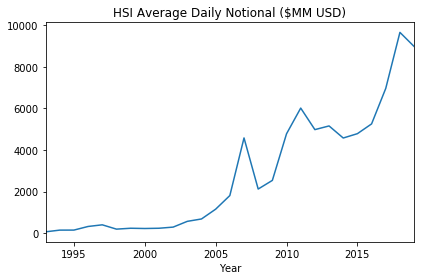

In [2]:
main('HSI')

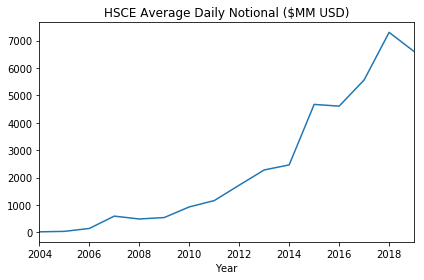

In [3]:
main('hsce')

In [60]:
import logging
import aiohttp
import async_timeout
import io
import asyncio
import pandas as pd
import datetime as dt
import pandas_datareader as pdr
import matplotlib.pyplot as plt

logging.basicConfig(level=logging.INFO)

HKEX_URL_ROOT = 'https://www.hkex.com.hk/eng/cbbc/download/CBBC{:02d}.zip'

SOURCE = 'yahoo'

USD_HKD_FX = 7.72

def adjust_symbol(symbol):
    if symbol.isnumeric():
        dts_symbol = '{:05d}'.format(int(symbol))
        yahoo_symbol = '{:04d}.HK'.format(int(symbol))
    elif symbol == 'HSCE':
        dts_symbol = 'HSCEI'
        yahoo_symbol = '^HSCE'
    else:
        dts_symbol = symbol
        if symbol == 'HSCEI':
            symbol = symbol[:-1]
        yahoo_symbol = '^{}'.format(symbol)
    return dts_symbol, yahoo_symbol


async def download_coroutine(session, url, data_dict):
    logging.info('attempting download of {}'.format(url))
    file_name = url.split('/')[-1]
    with async_timeout.timeout(600):
        async with session.get(url) as response:
            bytes_written = 0
            last_log = dt.datetime.now()
            with io.BytesIO() as buffer:
                while True:
                    chunk = await response.content.read(1024)
                    if not chunk:
                        break
                    bytes_written += buffer.write(chunk)
                    if dt.datetime.now() - last_log > dt.timedelta(seconds=60):
                        logging.info('file: {} has written {} bytes into buffer'.format(
                                     file_name, bytes_written))
                        last_log = dt.datetime.now()

                df = pd.read_csv(buffer, compression='zip', encoding='utf-16', sep='\t', dtype={'CBBC Code': str})

    raw_length = len(df)
    # .loc does not play well with str.extract here for reasons unknown. works fine when tested on small dataframes
    df['CBBC Code'] = df['CBBC Code'].str.extract(r'(\d+)')

    mask = ~df['CBBC Code'].isna()
    df = df.loc[mask, :]
    updated_length = len(df)
    removed_records = raw_length - updated_length
    log_msg = '{} raw df length: {}, removed non-numeric cbbc codes, new length: {}. \033[32m {} records removed' \
              '\033[0m'
    logging.info(log_msg.format(
                 file_name, raw_length, updated_length, removed_records
                 ))

    if removed_records != 3:
        raise AssertionError('dropping non-numeric cbbc codes should remove 3 records. instead {} removed'.format(
            removed_records
        ))

    data_dict[file_name] = df

    return await response.release()


async def get_data(loop, url_list, data_dict):

    async with aiohttp.ClientSession(loop=loop) as session:
        await asyncio.gather(*(download_coroutine(session, url, data_dict) for url in url_list))


def main(symbol, issuers=False, value="notional"):
    value = value.lower()
    available_columns = ['notional', 'volume', 'turnover']
    if value not in available_columns:
        raise ValueError('value must be one of {}'.format(', '.join(available_columns)))
    dts_symbol, yahoo_symbol = adjust_symbol(symbol.upper())
    logging.info('symbol: {} being converted to {} for dts and {} for yahoo'.format(
        symbol, dts_symbol, yahoo_symbol))

    file_urls = [HKEX_URL_ROOT.format(i) for i in range(1, 13)]
    data_dict = {}
    loop = asyncio.get_event_loop()
    loop.run_until_complete(get_data(loop, file_urls, data_dict))

    final_df = pd.concat(data_dict.values(), axis=0)

    # clean up column names
    column_names = [v.replace('*', '') for v in final_df.columns]
    column_names = [v.replace('^', '') for v in column_names]
    column_names = [v.replace('%', 'percent') for v in column_names]
    final_df.columns = column_names

    symbol_df = final_df.loc[final_df.loc[:, 'Underlying'] == dts_symbol, :]

    if len(symbol_df) == 0:
        logging.info('No CBBC volume for symbol {}'.format(dts_symbol))
        exit(0)

    symbol_df.loc[:, 'index units traded'] = symbol_df.apply(lambda x: x['Volume'] / x['Ent. Ratio'], axis=1)

    if issuers:
        index_unit_ts = symbol_df.groupby(['Trade Date', 'Issuer']).sum()
        index_unit_ts = index_unit_ts.loc[:, ['index units traded', 'Volume', 'Turnover']]
        index_unit_ts = index_unit_ts.unstack('Issuer')
    else:
        index_unit_ts = symbol_df.groupby('Trade Date').sum()
        index_unit_ts = index_unit_ts.loc[:, ['index units traded', 'Volume', 'Turnover']]

    start = index_unit_ts.index[0]
    end = index_unit_ts.index[-1]

    if value == 'notional':
        close_price_data = pdr.data.DataReader(yahoo_symbol, SOURCE, start, end)

        notional_df = index_unit_ts.loc[:, 'index units traded'] * close_price_data.Close

        notional_df *= (1/(USD_HKD_FX*1e6))

        notional_df.plot(title='{} CBBC Daily Notional Traded ($MM USD)'.format(symbol))

    elif value == 'contracts':
        index_unit_ts['Volume'].plot(title='{} CBBC Daily Volume'.format(symbol))

    elif value == 'turnover':
        index_unit_ts['Turnover'].apply(lambda x: x / USD_HKD_FX / 1e6).plot(
            title='{} CBBC Daily Turnover Traded ($MM USD)'.format(symbol)
        )

    plt.tight_layout()
    plt.show()

INFO:root:symbol: HSI being converted to HSI for dts and ^HSI for yahoo
INFO:root:attempting download of https://www.hkex.com.hk/eng/cbbc/download/CBBC01.zip
INFO:root:attempting download of https://www.hkex.com.hk/eng/cbbc/download/CBBC02.zip
INFO:root:attempting download of https://www.hkex.com.hk/eng/cbbc/download/CBBC03.zip
INFO:root:attempting download of https://www.hkex.com.hk/eng/cbbc/download/CBBC04.zip
INFO:root:attempting download of https://www.hkex.com.hk/eng/cbbc/download/CBBC05.zip
INFO:root:attempting download of https://www.hkex.com.hk/eng/cbbc/download/CBBC06.zip
INFO:root:attempting download of https://www.hkex.com.hk/eng/cbbc/download/CBBC07.zip
INFO:root:attempting download of https://www.hkex.com.hk/eng/cbbc/download/CBBC08.zip
INFO:root:attempting download of https://www.hkex.com.hk/eng/cbbc/download/CBBC09.zip
INFO:root:attempting download of https://www.hkex.com.hk/eng/cbbc/download/CBBC10.zip
INFO:root:attempting download of https://www.hkex.com.hk/eng/cbbc/do

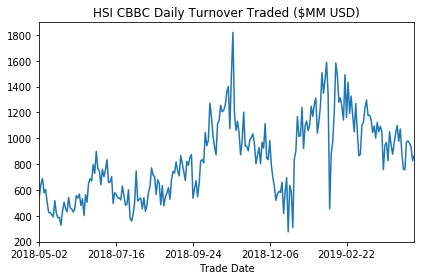

In [61]:
main('HSI', value='turnover')

In [59]:
# REVENUES
ave_contracts_per_day = 1e11
frac_hft = 0.9
# trade outcomes and probabilities
# {buy/signal right/sell same price:
#      prob ~ prob(signal right) * prob(tick down), pnl: 0
#  buy/signal right/sell one tick higher:
#      prob ~ prob(signal right) * prob(tick up) * (1-prob(issuer lowers tv)), pnl: 1
#  buy/signal right/sell half tick lower: (issuer lowers tv amend/widens)
#      prob ~ prob(signal right) * prob(tick up) * prob(issuer lowers tv), pnl: -0.5
#  buy/signal wrong/sell one tick lower:
#      prob ~ prob(signal wrong), pnl: -1
# }
prob_signal_right = 0.85
prob_issuer_lowers_tv = 0.25
events = {
    0: prob_signal_right * 0.5,
    1: prob_signal_right * 0.5 * (1-prob_issuer_lowers_tv),
    -0.5: prob_signal_right * 0.5 * prob_issuer_lowers_tv,
    -1: (1-prob_signal_right)
}
expected_edge_per_contract = sum([val * prob for val, prob in events.items()]) * 0.001
usd_hkd_fx = 7.72
expected_street_revs = ave_contracts_per_day * expected_edge_per_contract * frac_hft / 7.72

# EXPENSES
# https://www.hkex.com.hk/Services/Rules-and-Forms-and-Fees/Fees/Securities-(Hong-Kong)/Trading/Transaction?sc_lang=en
ave_turnover_per_day_usd = 800e6
transaction_levy = 0.000027
investor_compensation_levy = 0.00002
trading_fee = 0.00005
trading_fee_per_contract_hkd = 0.5
exch_fees = (ave_turnover_per_day_usd 
             * (transaction_levy + investor_compensation_levy + trading_fee))
print('expected revenues: {:,.0f}, expected exchange expenses: {:,.0f}'.format(
    expected_street_revs, exch_fees))

expected revenues: 1,347,960, expected exchange expenses: 77,600
